### 1. package import

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

### 2. Data Wrangling

In [2]:
train_data = pd.read_csv("./data_in/train.csv").iloc[:, 1:].dropna(how = 'any')
train_data.index = range(len(train_data))
test_data = pd.read_csv("./data_in/test.csv").iloc[:, 1:]
submission = pd.read_csv("./data_in/sample_submission.csv")

In [3]:
train_data.shape, test_data.shape

((39992, 2), (5000, 1))

In [4]:
train_data['data'] = train_data['data'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [5]:
train_data['data'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

category    0
data        0
dtype: int64


In [6]:
train_data.loc[train_data.data.isnull()][:5]

,category,data


In [7]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

39992


In [8]:
# test_data.drop_duplicates(subset = ['data'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['data'] = test_data['data'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글 이외 삭제
# test_data['data'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
# test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data['data']))

전처리 후 테스트용 샘플의 개수 : 5000


### Mecab Tokenizing

In [9]:
from konlpy.tag import Mecab
mecab = Mecab()

In [10]:
stop_words = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을']

### Take nouns by Mecab

In [11]:
X_train = []

text = list(train_data['data'])

for i in tqdm(range(len(text))):
  temp_X = []
  temp_X = mecab.nouns(text[i]) # 토큰화
  temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
  temp_X = [word for word in temp_X if len(word) > 1]
  X_train.append(temp_X)

100%|██████████| 39992/39992 [00:57<00:00, 700.36it/s]


In [12]:
X_test = []

text = list(test_data['data'])

for i in tqdm(range(len(text))):
  temp_X = []
  temp_X = mecab.nouns(text[i]) # 토큰화
  temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
  # temp_X = [word for word in temp_X if len(word) > 1]
  X_test.append(temp_X)

100%|██████████| 5000/5000 [00:07<00:00, 705.42it/s]


In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow.keras.backend as K

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [15]:
threshold = 11
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 45833
등장 빈도가 10번 이하인 희귀 단어의 수: 33115
단어 집합에서 희귀 단어의 비율: 72.25143455588768
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.134287559411337


In [16]:
vocab_size = total_cnt - rare_cnt + 1 # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 12719


In [17]:
tokenizer = Tokenizer(num_words = 2048) # num_words = vocab_size
tokenizer.fit_on_texts(X_train)
token_X_train = tokenizer.texts_to_sequences(X_train)
token_X_test = tokenizer.texts_to_sequences(X_test)

In [18]:
y_train = to_categorical(np.array(train_data['category']))

In [19]:
drop_train = [index for index, sentence in enumerate(token_X_train) if len(sentence) < 1]

In [20]:
# 빈 샘플들을 제거
del_X_train = np.delete(token_X_train, drop_train, axis=0)
del_y_train = np.delete(y_train, drop_train, axis=0)
print(len(del_X_train))
print(len(del_y_train))

39926
39926


/home/ubuntu/anaconda3/envs/TF2_37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


train data의 최대 길이 : 4859
train data의 평균 길이 : 57.76852176526574


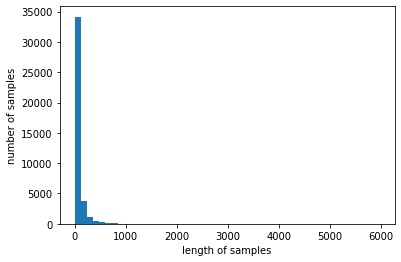

In [21]:
print('train data의 최대 길이 :',max(len(l) for l in del_X_train))
print('train data의 평균 길이 :',sum(map(len, del_X_train))/len(del_X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

test data의 최대 길이 :  3155
test data의 평균 길이 :  57.2548


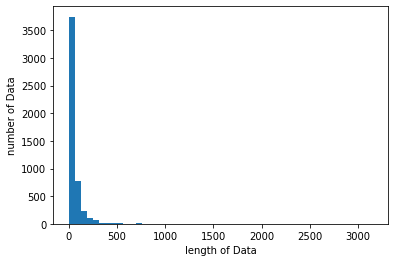

In [22]:
print("test data의 최대 길이 : ", max(len(l) for l in token_X_test))
print("test data의 평균 길이 : ", sum(map(len, token_X_test))/ len(token_X_test))
plt.hist([len(s) for s in token_X_test], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [23]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [24]:
max_len = 2048
below_threshold_len(max_len, del_X_train)

전체 샘플 중 길이가 2048 이하인 샘플의 비율: 99.99499073285578


In [25]:
pad_X_train = pad_sequences(del_X_train, maxlen = max_len)
pad_X_test = pad_sequences(token_X_test, maxlen = max_len)

In [26]:
from k_maxpooling import *
from vdcnn import *
from datetime import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import *

In [27]:
# pad_x_train, del_y_train // pad_X_test

In [28]:
pad_X_train[pad_X_train>2048]

array([], dtype=int32)

In [30]:
def train(x_train, y_train):
    
    # Init Keras Model here
    model = VDCNN(num_classes=3, 
                  sequence_length=2048,
                  shortcut=True,
                  pool_type='k_max', 
                  sorted=False, 
                  use_bias=False, embedding_dim=256, depth=17)
    
    # SGD(lr=0.006, momentum=0.99), adam
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Trainer
    # Tensorboard and extra callback to support steps history
    # tensorboard = TensorBoard(log_dir='./logs', histogram_freq=50, write_graph=True, write_images=True)
    checkpoint_path = "./checkpoints/vdcnn_weights.ckpt"
    checkpointer = ModelCheckpoint(filepath=checkpoint_path, #period=1,
                                   verbose=10, save_best_only=True, save_weights_only=True, 
                                   mode='max', monitor='val_accuracy')
    
    # loss_history = custom_callbacks.loss_history(model, tensorboard)
    # evaluate_step = custom_callbacks.evaluate_step(model, checkpointer, 100, BATCH_SIZE, x_test, y_test)

    # Fit model
    model.fit(x_train, y_train, batch_size=64, epochs=25, validation_split=0.2, 
              verbose=1, callbacks=[checkpointer])
    print('-'*30)
    time_str = datetime.now().strftime('%Y-%m-%d %H_%M_%S')
    print(f'{time_str}: Done training.')
    K.clear_session()
    
    model.load_weights(checkpoint_path)
    return model

if __name__=='__main__':
    
    model = train(x_train=pad_X_train, y_train=del_y_train)
    model.save('vdcnn_try.h5')

(None, 2048)
Model: "VDCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 2048, 256)    524288      inputs[0][0]                     
__________________________________________________________________________________________________
temp_conv (Conv1D)              (None, 2048, 64)     49216       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 2048, 64)     12352       temp_conv[0][0]                  
_________________________________________________________________________________

Epoch 1/25
499/500 [============================>.] - ETA: 0s - loss: 1.1033 - accuracy: 0.7333
Epoch 00001: val_accuracy improved from -inf to 0.80240, saving model to ./checkpoints/vdcnn_weights.ckpt
500/500 [==============================] - 113s 225ms/step - loss: 1.1033 - accuracy: 0.7333 - val_loss: 0.5448 - val_accuracy: 0.8024
Epoch 2/25
499/500 [============================>.] - ETA: 0s - loss: 0.3957 - accuracy: 0.8526
Epoch 00002: val_accuracy did not improve from 0.80240
500/500 [==============================] - 111s 221ms/step - loss: 0.3959 - accuracy: 0.8526 - val_loss: 1.8515 - val_accuracy: 0.4694
Epoch 3/25
499/500 [============================>.] - ETA: 0s - loss: 0.3751 - accuracy: 0.8611
Epoch 00003: val_accuracy improved from 0.80240 to 0.84210, saving model to ./checkpoints/vdcnn_weights.ckpt
500/500 [==============================] - 111s 223ms/step - loss: 0.3754 - accuracy: 0.8611 - val_loss: 0.4390 - val_accuracy: 0.8421
Epoch 4/25
499/500 [=================

In [31]:
# model = load_model('vdcnn_try.h5')
y_pred = model.predict(pad_X_test)
sample_submission = pd.read_csv('./data_in/sample_submission.csv')
sample_submission['category'] = np.argmax(y_pred, axis=-1)
sample_submission.head()

,index,category
0,0,0
1,1,2
2,2,1
3,3,0
4,4,2


In [32]:
sample_submission.to_csv('submission_'+ datetime.now().strftime('%Y-%m-%d %H_%M_%S') + '.csv', encoding='utf-8', index=False)